In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym_bandits
import gym
import math

env = gym.make("BanditTenArmedGaussian-v0")

In [2]:
env.action_space

Discrete(10)

## Epsilon Greedy Policy

In [91]:
class EpsilonGreedyPolicy:
    def __init__(self):
        self.Q = self.initialize_zeros(10)
        self.sum_rewards = self.initialize_zeros(10)
        self.count = self.initialize_zeros(10)
    
    def initialize_zeros(self, num_arms):
        return np.zeros(num_arms)
    
    def epsilon_greedy(self, epsilon):
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else: 
            action = np.argmax(self.Q)  
        return action
    
    def pull_arm(self, num_rounds):
        for i in range(num_rounds):
            
            # Select the arm using epsilon greedy
            arm = self.epsilon_greedy(0.5)

            # Get the reward
            observation, reward, done, info = env.step(arm)

            # update the count of that arm
            self.count[arm] += 1

            # Sum the rewards obtained from the arm
            self.sum_rewards[arm]+=reward

            # calculate Q value which is the average rewards of the arm
            self.Q[arm] = self.sum_rewards[arm]/self.count[arm]
        
        print('Completed. The optimal arm is {}'.format(np.argmax(self.Q)))
    
    def check_Q(self):
        print("The Q-values are:\n",self.Q)
    
    def check_sum_rewards(self):
        print("The rewards sum are:\n",self.sum_rewards)
        
    def check_arm_count(self):
        print("Counts of each arm:\n",self.count)
        
    def plot_arm_count(self, arm):
        x = np.arange(10)
        freq = arm
        width = 0.8 # width of the bars
        fig, ax = plt.subplots()
        rects1 = ax.bar(x, freq, width, color='g')

        ax.set_ylabel('Counts')
        ax.set_xlabel('Arm')
        plt.xticks(np.arange(0, 10, 1.0))

        def autolabel(rects):
            # attach some text labels
            for rect in rects:
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                        '%d' % int(height),
                        ha='center', va='bottom')

        autolabel(rects1)

        plt.show()

In [92]:
num_epochs = 20000
epsilon_greedy_policy = EpsilonGreedyPolicy()
epsilon_greedy_policy.pull_arm(num_epochs)
print()
epsilon_greedy_policy.check_Q()
print()
epsilon_greedy_policy.check_sum_rewards()
print()
epsilon_greedy_policy.check_arm_count()

Completed. The optimal arm is 5

The Q-values are:
 [-1.21885008 -0.96572249 -0.73974698 -0.38769185 -0.05345502  1.41690208
 -1.54942927 -0.32392298 -0.53177997  0.26095474]

The rewards sum are:
 [-1181.06572785  -945.44231791  -746.40470238  -380.7133992
   -52.54628543 15669.52013448 -1640.8455961   -302.86798414
  -529.65285176   268.5224243 ]

Counts of each arm:
 [  969.   979.  1009.   982.   983. 11059.  1059.   935.   996.  1029.]


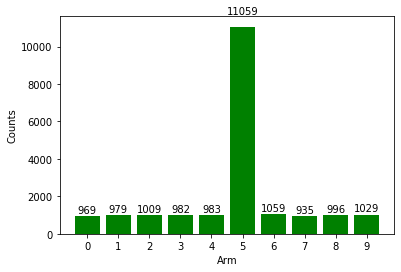

In [94]:
epsilon_greedy_policy.plot_arm_count(epsilon_greedy_policy.count)

## Softmax Exploration Policy

In [101]:
class SoftmaxExploration:
    def __init__(self):
        self.Q = self.initialize_zeros(10)
        self.sum_rewards = self.initialize_zeros(10)
        self.count = self.initialize_zeros(10)

    def initialize_zeros(self, num_arms):
        return np.zeros(num_arms)
    
    def softmax_probability(self, tau):
        total = sum([math.exp(val/tau) for val in self.Q])
        probs = [math.exp(val/tau)/total for val in self.Q]
        threshold = np.random.random()
        cumulative_prob = 0.0

        for i in range(len(probs)):
            cumulative_prob += probs[i]
            if (cumulative_prob > threshold):
                return i
        return np.argmax(probs)
    
    def pull_arm(self, num_rounds):
        for i in range(num_rounds):
            
            # Select the arm using softmax
            arm = self.softmax_probability(0.5)
            observation, reward, done, info = env.step(arm)
            self.count[arm] += 1
            self.sum_rewards[arm]+=reward
            self.Q[arm] = self.sum_rewards[arm]/self.count[arm]
        
        print('Completed. The optimal arm is {}'.format(np.argmax(self.Q)))
    
    def check_Q(self):
        print("The Q-values are:\n",self.Q)
    
    def check_sum_rewards(self):
        print("The rewards sum are:\n",self.sum_rewards)
        
    def check_arm_count(self):
        print("Counts of each arm:\n",self.count)
        
    def plot_arm_count(self, arm):
        x = np.arange(10)
        freq = arm
        width = 0.8 # width of the bars
        fig, ax = plt.subplots()
        rects1 = ax.bar(x, freq, width, color='m')

        ax.set_ylabel('Counts')
        ax.set_xlabel('Arm')
        plt.xticks(np.arange(0, 10, 1.0))

        def autolabel(rects):
            # attach some text labels
            for rect in rects:
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                        '%d' % int(height),
                        ha='center', va='bottom')

        autolabel(rects1)
        plt.show()

In [102]:
num_epochs = 20000
softmax_policy = SoftmaxExploration()
softmax_policy.pull_arm(num_epochs)
print()
softmax_policy.check_Q()
print()
softmax_policy.check_sum_rewards()
print()
softmax_policy.check_arm_count()

Completed. The optimal arm is 5

The Q-values are:
 [-1.91536428 -0.85127048 -0.6582483  -0.44891601 -0.01759642  1.41377236
 -1.49691825 -0.27596157 -0.48610478  0.30344795]

The rewards sum are:
 [-9.57682140e+00 -1.22582949e+02 -1.48764116e+02 -1.72832662e+02
 -1.60479318e+01  2.20704004e+04 -8.23305039e+01 -1.56194247e+02
 -2.02219590e+02  5.09792548e+02]

Counts of each arm:
 [5.0000e+00 1.4400e+02 2.2600e+02 3.8500e+02 9.1200e+02 1.5611e+04
 5.5000e+01 5.6600e+02 4.1600e+02 1.6800e+03]


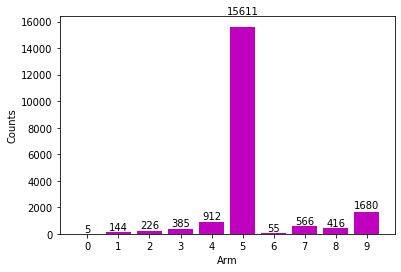

In [103]:
softmax_policy.plot_arm_count(softmax_policy.count)

In [32]:
def UCB(iters):
    
    ucb = np.zeros(10)
    
    # check if consists at least 10 sample
    if iters < 10:
        return i 
    else:
        for arm in range(10):
            # calculate upper bound
            upper_bound = math.sqrt((2*math.log(sum(count))) / count[arm])
            
            # add upper bound to the Q value
            ucb[arm] = Q_UCB[arm] + upper_bound
        
    # return the arm which has maximum value
    return (np.argmax(ucb))

In [33]:
for i in range(num_rounds):
    
    # Select the arm using UCB
    arm = UCB(i)

    observation, reward, done, info = env.step(arm)
    
    # update the count of that arm
    count[arm] += 1
    
    # Sum the rewards obtained from the arm
    sum_rewards[arm]+=reward
    
    # calculate Q value which is the average rewards of the arm
    Q_UCB[arm] = sum_rewards[arm]/count[arm]
    
print( 'The optimal arm is {}'.format(np.argmax(Q)))

The optimal arm is 0


In [39]:
def thompson_sampling(alpha,beta):
    samples = [np.random.beta(alpha[i]+1,beta[i]+1) for i in range(10)]
    return np.argmax(samples)

for i in range(num_rounds):

    arm = thompson_sampling(alpha,beta)

    observation, reward, done, info = env.step(arm)

    count[arm] += 1

    sum_rewards[arm]+=reward

    Q[arm] = sum_rewards[arm]/count[arm]
    
    # If it is a positive reward increment alpha
    if reward >0:
        alpha[arm] += 1
    # If it is a negative reward increment beta
    else:
        beta[arm] += 1

print( 'The optimal arm is {}'.format(np.argmax(Q)))

The optimal arm is 0


In [16]:
for i in range(num_rounds):

    # arm using epsilon greedy
    arm = epsilon_greedy(0.5)
    
    # arm using softmax
    arm = softmax(0.5)

    observation, reward, done, info = env.step(arm)

    count[arm] += 1

    sum_rewards[arm]+=reward

    # calculate Q value which is the average rewards of the arm
    Q[arm] = sum_rewards[arm]/count[arm]
    
print( 'The optimal arm is {}'.format(np.argmax(Q)))

The optimal arm is 4


In [18]:
Q

array([ 1.19831264,  0.33350828,  0.76601153, -0.3355797 ,  2.0204708 ,
       -0.98286558,  1.66036175, -0.47403209,  0.23711068, -0.55311812])